Importing Libraries

In [1]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import seaborn as sns
import gensim
import re, string, unicodedata
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading Dataset

In [2]:
#loading data from google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


train_file_id = '1gfU_3JLesTYMDve8C6dMks9__dv5JT-5'
#test_file_id = '1J4K-z82tEr4jkwG1Hl1t-eigpcivqt3k' 

download = drive.CreateFile({'id': train_file_id})
download.GetContentFile('train.csv')
df  = pd.read_csv("train.csv")
df = df[['is_sarcastic', 'headline']]
df.head()


   Unnamed: 0  is_sarcastic                                           headline
0       20062             0   what your brain actually does when you multitask
1        9968             0  'the daily show' puts trump supporters through...
2        3720             0  @USER people are walking around like zombies ,...
3       14183             0  women rewrite the constitution in jay-z's 'fam...
4        3731             1  unpublished twain autobiography rails against ...


#Model Implementation

Baseline model - word2vec

In [3]:
df.isna().sum() # Checking for NaN values

Unnamed: 0      0
is_sarcastic    0
headline        0
dtype: int64

In [4]:
df.head()

,Unnamed: 0,is_sarcastic,headline
0,20062,0,what your brain actually does when you multitask
1,9968,0,'the daily show' puts trump supporters through...
2,3720,0,"@USER people are walking around like zombies ,..."
3,14183,0,women rewrite the constitution in jay-z's 'fam...
4,3731,1,unpublished twain autobiography rails against ...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


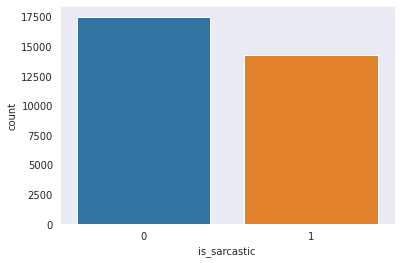

In [6]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

Our dataset is balanced.

In [7]:
stop = set(stopwords.words('english'))

def remove_masked_user(text):
    return text.replace('@USER', '')

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

'''
def remove_url(text):
  return text.replace('<url>', '')

'''

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = remove_masked_user(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
#df['response']=df['response'].apply(denoise_text)
#print ('<url>' in df['response'] )

In [9]:
words = []
for i in df.headline.values:
    words.append(i.split())
#words[-1] = words[-1].append('<url>')
words[:3]


[['what', 'your', 'brain', 'actually', 'does', 'when', 'you', 'multitask'],
 ["'the",
  'daily',
  "show'",
  'puts',
  'trump',
  'supporters',
  'through',
  'some',
  "'extreme",
  "vetting'"],
 ['@USER',
  'people',
  'are',
  'walking',
  'around',
  'like',
  'zombies',
  ',',
  'bursting',
  'into',
  'tears',
  'while',
  'talking',
  'to',
  'complete',
  'strangers',
  '.',
  '#grief',
  '#fearYou',
  'are',
  'an',
  'insane',
  'person',
  '.',
  'You',
  'think',
  'hundreds',
  'of',
  'thousands',
  'of',
  'people',
  'across',
  'the',
  'country',
  'are',
  'not',
  'real',
  'people',
  '?',
  "they're",
  '…',
  '<URL>',
  '@USER',
  "It's",
  "Twitter's",
  'fault',
  '.',
  'Part',
  'of',
  'me',
  'wants',
  'to',
  'laugh',
  'but',
  "it's",
  'not',
  'actually',
  'remotely',
  'funny',
  '.',
  '@USER',
  "You're",
  'right',
  '.',
  'On',
  'the',
  'one',
  'hand',
  "it's",
  'hilarious',
  '.',
  'On',
  'the',
  'other',
  'hand',
  ',',
  'everyone'

In [10]:
print('<url>' in words)

False


In [11]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 200
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [12]:
#vocab size
len(w2v_model.wv.vocab)

70572

In [ ]:
#url_token = w2v_model.wv['<url>']

In [13]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 20)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if '@user' or '<url>' == word: continue
        weight_matrix[i] = model[word]
    return weight_matrix

In [15]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [16]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           12184400  
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12,577,041
Trainable params: 12,577,041
Non-trainable params: 0
_________________________________________________________________


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [19]:
df.is_sarcastic

0        0
1        0
2        0
3        0
4        1
        ..
31704    0
31705    0
31706    0
31707    1
31708    1
Name: is_sarcastic, Length: 31709, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


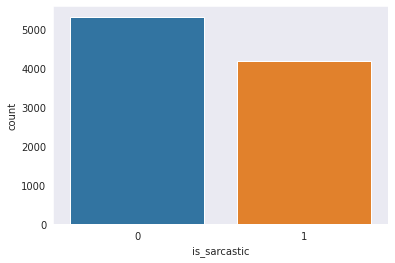

In [20]:
sns.set_style("dark")
sns.countplot(y_test)

In [21]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 15)

Epoch 1/15
174/174 [==============================] - 132s 695ms/step - loss: 0.4649 - acc: 0.7727 - val_loss: 0.3783 - val_acc: 0.8220
Epoch 2/15
174/174 [==============================] - 116s 668ms/step - loss: 0.2102 - acc: 0.9099 - val_loss: 0.4315 - val_acc: 0.8161
Epoch 3/15
174/174 [==============================] - 117s 671ms/step - loss: 0.0989 - acc: 0.9618 - val_loss: 0.5480 - val_acc: 0.8079
Epoch 4/15
174/174 [==============================] - 114s 657ms/step - loss: 0.0455 - acc: 0.9827 - val_loss: 0.7954 - val_acc: 0.8064
Epoch 5/15
174/174 [==============================] - 116s 664ms/step - loss: 0.0277 - acc: 0.9904 - val_loss: 0.9695 - val_acc: 0.8036
Epoch 6/15
174/174 [==============================] - 115s 662ms/step - loss: 0.0204 - acc: 0.9929 - val_loss: 1.0989 - val_acc: 0.8056
Epoch 7/15
174/174 [==============================] - 115s 660ms/step - loss: 0.0171 - acc: 0.9946 - val_loss: 1.1002 - val_acc: 0.8001
Epoch 8/15
174/174 [============================

In [22]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

694/694 [==============================] - 41s 58ms/step - loss: 0.0039 - acc: 0.9988
Accuracy of the model on Training Data is -  99.88285899162292
298/298 [==============================] - 8s 27ms/step - loss: 1.5070 - acc: 0.7982
Accuracy of the model on Testing Data is -  79.81709241867065


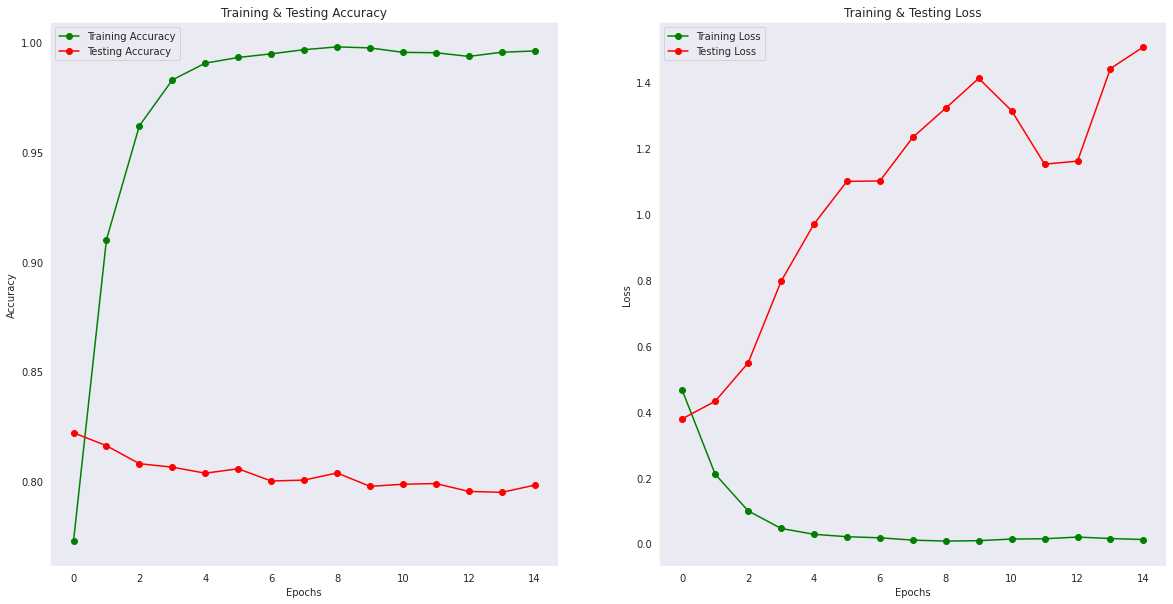

In [23]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [24]:
y_proba = model.predict_on_batch(x_test)
y_pred = y_proba.argmax(axis=-1)

In [25]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[5319,    0],
       [4194,    0]])

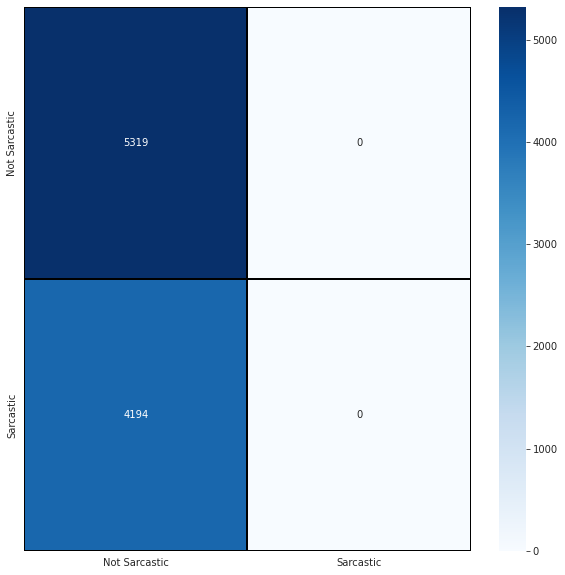

In [26]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])